In [1]:
# 구글 드라이브 MOUNT
from google.colab import drive
drive.mount('/content/drive')

# github와 연동하고 싶은 폴더로 이동
%cd /content/drive/MyDrive/study_DL/Study_DL


Mounted at /content/drive
/content/drive/MyDrive/study_DL/Study_DL


# [kaggle] Denoising Dirty Documents 
https://www.kaggle.com/competitions/denoising-dirty-documents



# 파일 불러오기

## 방법1: 로컬에서 불러오기

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 8.png to 8.png
Saving 9.png to 9.png
Saving 11.png to 11.png
Saving 12.png to 12.png
Saving 14.png to 14.png
Saving 15.png to 15.png
Saving 17.png to 17.png
Saving 18.png to 18.png
Saving 20.png to 20.png
Saving 21.png to 21.png
Saving 23.png to 23.png
Saving 24.png to 24.png
Saving 26.png to 26.png
Saving 27.png to 27.png
Saving 29.png to 29.png
Saving 30.png to 30.png
Saving 32.png to 32.png
Saving 33.png to 33.png
Saving 35.png to 35.png
Saving 36.png to 36.png
Saving 38.png to 38.png
Saving 39.png to 39.png
Saving 41.png to 41.png
Saving 42.png to 42.png
Saving 44.png to 44.png
Saving 45.png to 45.png
Saving 47.png to 47.png
Saving 48.png to 48.png
Saving 50.png to 50.png
Saving 51.png to 51.png
Saving 53.png to 53.png
Saving 54.png to 54.png
Saving 56.png to 56.png
Saving 57.png to 57.png
Saving 59.png to 59.png
Saving 60.png to 60.png
Saving 62.png to 62.png
Saving 63.png to 63.png
Savi

In [ ]:
filename_li = []

for i in uploaded.keys():
  filename_li.append(i)

print(filename_li[:10])

['2.png', '3.png', '5.png', '6.png', '8.png', '9.png', '11.png', '12.png', '14.png', '15.png']


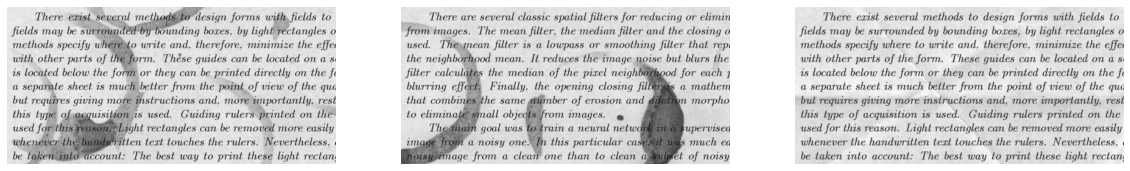

In [ ]:
plt.figure(figsize = (20, 6))

for i in range(3):
  plt.subplot(1, 3, i+1)
  img_arr = cv2.imread(filename_li[i])
  plt.imshow(img_arr)
  plt.axis('off')
plt.show()

## 방법2: google drive zipfile 형태로 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
path_zip = '../필요데이터/kaggle_noise_text/'

In [ ]:
import zipfile

with zipfile.ZipFile(os.path.join(path_zip, 'archive.zip'), 'r') as zip_ref:
  zip_ref.extractall(path_zip)


In [4]:
train_img_path = [os.path.join(path_zip, f'train/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'train')))]
test_img_path = [os.path.join(path_zip, f'test/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'test')))]

train_cleaned_img_path = [os.path.join(path_zip, f'train_cleaned/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'train_cleaned')))]

In [5]:
len(train_img_path), len(test_img_path), len(train_cleaned_img_path)

(144, 72, 144)

# 이미지 불러오고 전처리하는 사용자함수 만들기

In [6]:
arr = cv2.imread(train_img_path[0])
arr.shape

(420, 540, 3)

In [7]:
input_shape = (420, 540, 1)

In [8]:
def process_img(path):
  img = cv2.imread(path)  #(420, 540, 3)
  img = np.asarray(img, dtype = 'float32')
  img = cv2.resize(img, (input_shape[1], input_shape[0]))  # (420, 540, 3)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # (420, 540)
  img = img/255.
  img = np.reshape(img, input_shape) # (420, 540, 1)

  return img

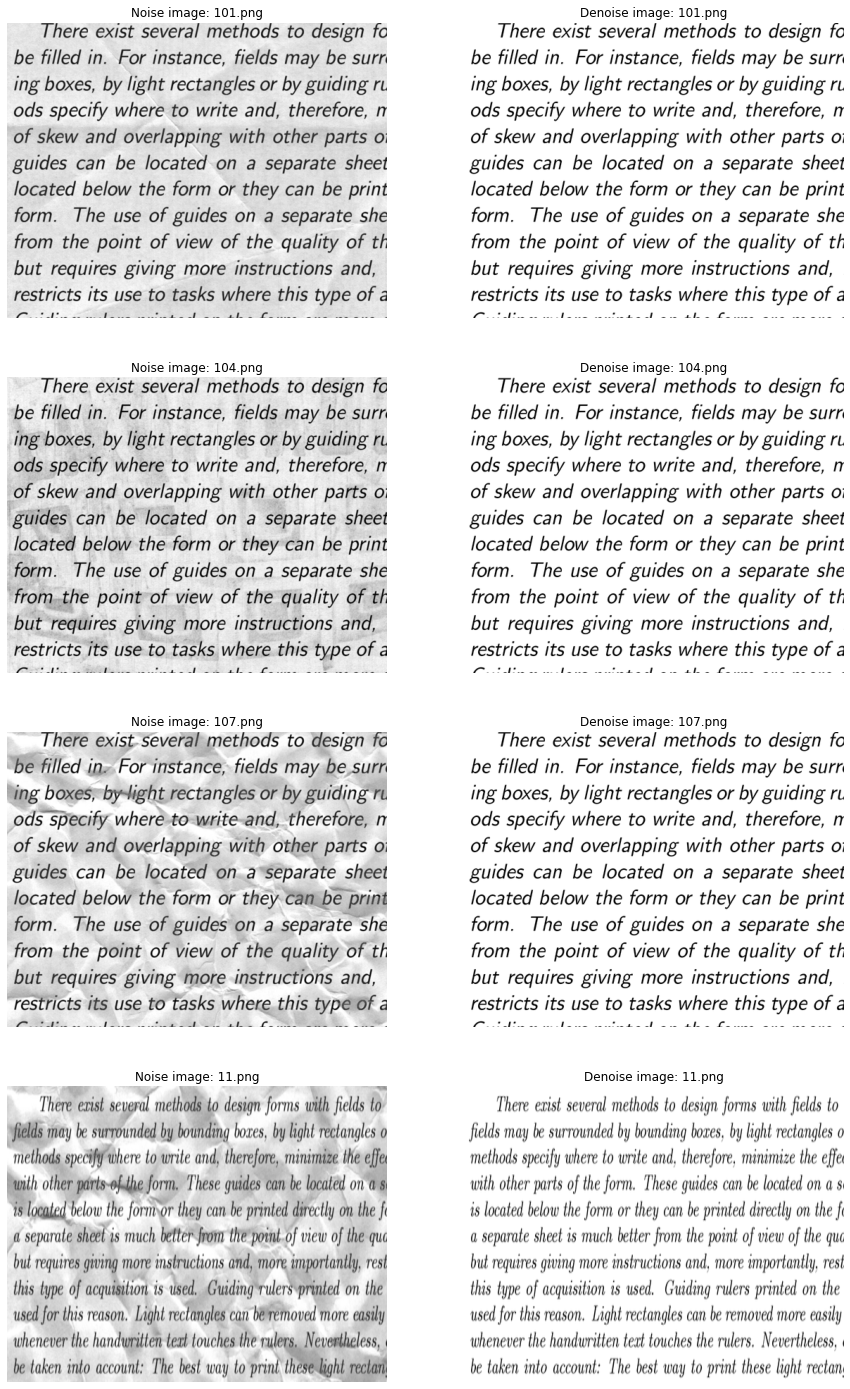

In [ ]:
plt.figure(figsize = (15,25))
for i in range(0, 8, 2):
  plt.subplot(4, 2, i + 1)
  plt.axis('off')
  plt.imshow(process_img(train_img_path[i])[:,:,0], cmap = 'gray')
  title = train_img_path[i].split('train/')[1]
  plt.title(f'Noise image: {title}')

  plt.subplot(4, 2, i + 2)
  plt.axis('off')
  plt.imshow(process_img(train_cleaned_img_path[i])[:,:,0], cmap = 'gray')
  title = train_cleaned_img_path[i].split('train_cleaned/')[1]
  plt.title(f'Denoise image: {title}')


In [9]:
train = [process_img(path) for path in train_img_path]
train_cleaned = [process_img(path) for path in train_cleaned_img_path]
test = [process_img(path) for path in test_img_path]

# 훈련/검증/테스트 데이터 나누기

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr = np.asarray(train)
y_tr = np.asarray(train_cleaned)
x_test = np.asarray(test)

x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size = 0.1)

In [12]:
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [
    {'filters': 64, 'kernel_size':3},
    {'filters': 128, 'kernel_size':3},
    {'filters': 256, 'kernel_size':3},
]

In [13]:
from keras import backend as K
from keras.layers import *
from tensorflow.keras.models import Model

In [16]:
def model():
  input_layer = Input(shape = input_shape)

  # 인코딩
  x = input_layer
  for layer_f in layer_filters:
    x = Conv2D(layer_f['filters'], layer_f['kernel_size'], 
               activation = 'relu', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(2, padding = 'same')(x)
  x = Dropout(0.5)(x)

  # 디코딩
  for layer_f in layer_filters[::-1]:
    x = Conv2D(layer_f['filters'], layer_f['kernel_size'], 
               activation = 'relu', padding = 'same')(x)

  x = BatchNormalization()(x)
  x = UpSampling2D(2)(x)

  output_layer = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(x)

  autoencoder = Model(input_layer, output_layer)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
  return autoencoder

In [17]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 256)     295168    
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 256)    1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 256)    0         
 )                                                           

In [18]:
model_weights_file_path = './save_model/savebest_model_weights.hdf5'

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath = 'model_weights_file_path',
                             monitor = 'val_loss',
                             mode = 'min',
                             verbose = 1,
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          verbose = 1,
                          patience = 30)

lr_reduce = ReduceLROnPlateau(monitor = 'val_loss',
                              mode = 'min',
                              factor = 0.5,
                              patience = 20,
                              verbose = 0,
                              min_delta = 0.0001,
                              cooldown = 0,
                              min_lr = 0)


In [21]:
callbacks = [checkpoint, earlystop, lr_reduce]
epochs = 500
batch_size = 8

In [24]:
history = model.fit(x_train, y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val))

Epoch 1/500
17/17 [==============================] - ETA: 0s - loss: 0.1210 - mae: 0.2560
Epoch 1: val_loss improved from inf to 0.15627, saving model to model_weights_file_path


17/17 [==============================] - 75s 3s/step - loss: 0.1210 - mae: 0.2560 - val_loss: 0.1563 - val_mae: 0.3833 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - ETA: 0s - loss: 0.0482 - mae: 0.1625
Epoch 2: val_loss improved from 0.15627 to 0.07358, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0482 - mae: 0.1625 - val_loss: 0.0736 - val_mae: 0.2321 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.1242
Epoch 3: val_loss improved from 0.07358 to 0.06606, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0313 - mae: 0.1242 - val_loss: 0.0661 - val_mae: 0.1864 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - ETA: 0s - loss: 0.0217 - mae: 0.1026
Epoch 4: val_loss improved from 0.06606 to 0.06585, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0217 - mae: 0.1026 - val_loss: 0.0659 - val_mae: 0.1570 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0900
Epoch 5: val_loss did not improve from 0.06585
17/17 [==============================] - 33s 2s/step - loss: 0.0169 - mae: 0.0900 - val_loss: 0.0673 - val_mae: 0.1413 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0761
Epoch 6: val_loss did not improve from 0.06585
17/17 [==============================] - 32s 2s/step - loss: 0.0125 - mae: 0.0761 - val_loss: 0.0692 - val_mae: 0.1315 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0666
Epoch 7: val_loss did not improve from 0.06585
17/17 [==============================] - 32s 2s/step - loss: 0.0097 - mae: 0.0666 - val_loss: 0.0700 - val_mae: 0.1267 - lr: 0.0010
Epoch 8/500
17/17 [==============================] - ETA: 0s 

17/17 [==============================] - 34s 2s/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0655 - val_mae: 0.1046 - lr: 0.0010
Epoch 22/500
17/17 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0266
Epoch 22: val_loss improved from 0.06547 to 0.06222, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0023 - mae: 0.0266 - val_loss: 0.0622 - val_mae: 0.1020 - lr: 0.0010
Epoch 23/500
17/17 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0258
Epoch 23: val_loss improved from 0.06222 to 0.05976, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 0.0021 - mae: 0.0258 - val_loss: 0.0598 - val_mae: 0.0993 - lr: 0.0010
Epoch 24/500
17/17 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0255
Epoch 24: val_loss improved from 0.05976 to 0.05909, saving model to model_weights_file_path


17/17 [==============================] - 36s 2s/step - loss: 0.0022 - mae: 0.0255 - val_loss: 0.0591 - val_mae: 0.1003 - lr: 0.0010
Epoch 25/500
17/17 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0247
Epoch 25: val_loss improved from 0.05909 to 0.05473, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0020 - mae: 0.0247 - val_loss: 0.0547 - val_mae: 0.0971 - lr: 0.0010
Epoch 26/500
17/17 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0236
Epoch 26: val_loss improved from 0.05473 to 0.05146, saving model to model_weights_file_path


17/17 [==============================] - 36s 2s/step - loss: 0.0019 - mae: 0.0236 - val_loss: 0.0515 - val_mae: 0.0945 - lr: 0.0010
Epoch 27/500
17/17 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0231
Epoch 27: val_loss improved from 0.05146 to 0.04735, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0018 - mae: 0.0231 - val_loss: 0.0474 - val_mae: 0.0896 - lr: 0.0010
Epoch 28/500
17/17 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0226
Epoch 28: val_loss improved from 0.04735 to 0.04219, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0018 - mae: 0.0226 - val_loss: 0.0422 - val_mae: 0.0867 - lr: 0.0010
Epoch 29/500
17/17 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0221
Epoch 29: val_loss improved from 0.04219 to 0.03613, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 0.0017 - mae: 0.0221 - val_loss: 0.0361 - val_mae: 0.0875 - lr: 0.0010
Epoch 30/500
17/17 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0216
Epoch 30: val_loss improved from 0.03613 to 0.03134, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0017 - mae: 0.0216 - val_loss: 0.0313 - val_mae: 0.0770 - lr: 0.0010
Epoch 31/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0213
Epoch 31: val_loss improved from 0.03134 to 0.02828, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0016 - mae: 0.0213 - val_loss: 0.0283 - val_mae: 0.0784 - lr: 0.0010
Epoch 32/500
17/17 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0223
Epoch 32: val_loss did not improve from 0.02828
17/17 [==============================] - 33s 2s/step - loss: 0.0018 - mae: 0.0223 - val_loss: 0.0330 - val_mae: 0.0819 - lr: 0.0010
Epoch 33/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0212
Epoch 33: val_loss improved from 0.02828 to 0.01936, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0016 - mae: 0.0212 - val_loss: 0.0194 - val_mae: 0.0663 - lr: 0.0010
Epoch 34/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0210
Epoch 34: val_loss did not improve from 0.01936
17/17 [==============================] - 33s 2s/step - loss: 0.0016 - mae: 0.0210 - val_loss: 0.0207 - val_mae: 0.0607 - lr: 0.0010
Epoch 35/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0209
Epoch 35: val_loss improved from 0.01936 to 0.01607, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0016 - mae: 0.0209 - val_loss: 0.0161 - val_mae: 0.0604 - lr: 0.0010
Epoch 36/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0204
Epoch 36: val_loss improved from 0.01607 to 0.00758, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 0.0016 - mae: 0.0204 - val_loss: 0.0076 - val_mae: 0.0426 - lr: 0.0010
Epoch 37/500
17/17 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0200
Epoch 37: val_loss improved from 0.00758 to 0.00605, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0015 - mae: 0.0200 - val_loss: 0.0060 - val_mae: 0.0392 - lr: 0.0010
Epoch 38/500
17/17 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0195
Epoch 38: val_loss did not improve from 0.00605
17/17 [==============================] - 33s 2s/step - loss: 0.0015 - mae: 0.0195 - val_loss: 0.0086 - val_mae: 0.0410 - lr: 0.0010
Epoch 39/500
17/17 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0195
Epoch 39: val_loss did not improve from 0.00605
17/17 [==============================] - 33s 2s/step - loss: 0.0015 - mae: 0.0195 - val_loss: 0.0083 - val_mae: 0.0439 - lr: 0.0010
Epoch 40/500
17/17 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0197
Epoch 40: val_loss improved from 0.00605 to 0.00561, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0015 - mae: 0.0197 - val_loss: 0.0056 - val_mae: 0.0379 - lr: 0.0010
Epoch 41/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0198
Epoch 41: val_loss did not improve from 0.00561
17/17 [==============================] - 32s 2s/step - loss: 0.0016 - mae: 0.0198 - val_loss: 0.0072 - val_mae: 0.0374 - lr: 0.0010
Epoch 42/500
17/17 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0202
Epoch 42: val_loss did not improve from 0.00561
17/17 [==============================] - 32s 2s/step - loss: 0.0016 - mae: 0.0202 - val_loss: 0.0094 - val_mae: 0.0458 - lr: 0.0010
Epoch 43/500
17/17 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0197
Epoch 43: val_loss improved from 0.00561 to 0.00517, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0015 - mae: 0.0197 - val_loss: 0.0052 - val_mae: 0.0428 - lr: 0.0010
Epoch 44/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0190
Epoch 44: val_loss improved from 0.00517 to 0.00368, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0014 - mae: 0.0190 - val_loss: 0.0037 - val_mae: 0.0324 - lr: 0.0010
Epoch 45/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0190
Epoch 45: val_loss did not improve from 0.00368
17/17 [==============================] - 32s 2s/step - loss: 0.0014 - mae: 0.0190 - val_loss: 0.0046 - val_mae: 0.0354 - lr: 0.0010
Epoch 46/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0186
Epoch 46: val_loss improved from 0.00368 to 0.00221, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0014 - mae: 0.0186 - val_loss: 0.0022 - val_mae: 0.0278 - lr: 0.0010
Epoch 47/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0183
Epoch 47: val_loss improved from 0.00221 to 0.00168, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 0.0013 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0223 - lr: 0.0010
Epoch 48/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0180
Epoch 48: val_loss did not improve from 0.00168
17/17 [==============================] - 33s 2s/step - loss: 0.0013 - mae: 0.0180 - val_loss: 0.0023 - val_mae: 0.0248 - lr: 0.0010
Epoch 49/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0183
Epoch 49: val_loss did not improve from 0.00168
17/17 [==============================] - 32s 2s/step - loss: 0.0014 - mae: 0.0183 - val_loss: 0.0019 - val_mae: 0.0208 - lr: 0.0010
Epoch 50/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0178
Epoch 50: val_loss improved from 0.00168 to 0.00127, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0013 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0213 - lr: 0.0010
Epoch 51/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0176
Epoch 51: val_loss improved from 0.00127 to 0.00103, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0013 - mae: 0.0176 - val_loss: 0.0010 - val_mae: 0.0154 - lr: 0.0010
Epoch 52/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0177
Epoch 52: val_loss did not improve from 0.00103
17/17 [==============================] - 33s 2s/step - loss: 0.0013 - mae: 0.0177 - val_loss: 0.0015 - val_mae: 0.0180 - lr: 0.0010
Epoch 53/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0179
Epoch 53: val_loss did not improve from 0.00103
17/17 [==============================] - 33s 2s/step - loss: 0.0013 - mae: 0.0179 - val_loss: 0.0012 - val_mae: 0.0211 - lr: 0.0010
Epoch 54/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0177
Epoch 54: val_loss did not improve from 0.00103
17/17 [==============================] - 32s 2s/step - loss: 0.0013 - mae: 0.0177 - val_loss: 0.0015 - val_mae: 0.0202 - lr: 0.0010
Epoch 55/500
17/17 [==============================] - E

17/17 [==============================] - 35s 2s/step - loss: 0.0012 - mae: 0.0174 - val_loss: 9.8244e-04 - val_mae: 0.0200 - lr: 0.0010
Epoch 56/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0183
Epoch 56: val_loss did not improve from 0.00098
17/17 [==============================] - 33s 2s/step - loss: 0.0014 - mae: 0.0183 - val_loss: 0.0011 - val_mae: 0.0201 - lr: 0.0010
Epoch 57/500
17/17 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0179
Epoch 57: val_loss did not improve from 0.00098
17/17 [==============================] - 32s 2s/step - loss: 0.0014 - mae: 0.0179 - val_loss: 0.0010 - val_mae: 0.0162 - lr: 0.0010
Epoch 58/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0174
Epoch 58: val_loss did not improve from 0.00098
17/17 [==============================] - 32s 2s/step - loss: 0.0013 - mae: 0.0174 - val_loss: 0.0019 - val_mae: 0.0214 - lr: 0.0010
Epoch 59/500
17/17 [==============================]

17/17 [==============================] - 34s 2s/step - loss: 0.0013 - mae: 0.0177 - val_loss: 8.4693e-04 - val_mae: 0.0143 - lr: 0.0010
Epoch 62/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0171
Epoch 62: val_loss improved from 0.00085 to 0.00083, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0012 - mae: 0.0171 - val_loss: 8.2744e-04 - val_mae: 0.0149 - lr: 0.0010
Epoch 63/500
17/17 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0167
Epoch 63: val_loss did not improve from 0.00083
17/17 [==============================] - 33s 2s/step - loss: 0.0011 - mae: 0.0167 - val_loss: 0.0011 - val_mae: 0.0143 - lr: 0.0010
Epoch 64/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0174
Epoch 64: val_loss did not improve from 0.00083
17/17 [==============================] - 32s 2s/step - loss: 0.0013 - mae: 0.0174 - val_loss: 0.0018 - val_mae: 0.0217 - lr: 0.0010
Epoch 65/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0170
Epoch 65: val_loss improved from 0.00083 to 0.00081, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 0.0012 - mae: 0.0170 - val_loss: 8.1023e-04 - val_mae: 0.0130 - lr: 0.0010
Epoch 66/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0167
Epoch 66: val_loss did not improve from 0.00081
17/17 [==============================] - 33s 2s/step - loss: 0.0012 - mae: 0.0167 - val_loss: 8.3641e-04 - val_mae: 0.0149 - lr: 0.0010
Epoch 67/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0172
Epoch 67: val_loss did not improve from 0.00081
17/17 [==============================] - 32s 2s/step - loss: 0.0013 - mae: 0.0172 - val_loss: 0.0028 - val_mae: 0.0248 - lr: 0.0010
Epoch 68/500
17/17 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0175
Epoch 68: val_loss did not improve from 0.00081
17/17 [==============================] - 33s 2s/step - loss: 0.0013 - mae: 0.0175 - val_loss: 0.0018 - val_mae: 0.0195 - lr: 0.0010
Epoch 69/500
17/17 [===========================

17/17 [==============================] - 34s 2s/step - loss: 0.0011 - mae: 0.0161 - val_loss: 8.0268e-04 - val_mae: 0.0143 - lr: 0.0010
Epoch 73/500
17/17 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0161
Epoch 73: val_loss did not improve from 0.00080
17/17 [==============================] - 32s 2s/step - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0191 - lr: 0.0010
Epoch 74/500
17/17 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0164
Epoch 74: val_loss did not improve from 0.00080
17/17 [==============================] - 32s 2s/step - loss: 0.0011 - mae: 0.0164 - val_loss: 0.0017 - val_mae: 0.0194 - lr: 0.0010
Epoch 75/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0166
Epoch 75: val_loss did not improve from 0.00080
17/17 [==============================] - 33s 2s/step - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0162 - lr: 0.0010
Epoch 76/500
17/17 [==============================]

17/17 [==============================] - 34s 2s/step - loss: 0.0011 - mae: 0.0159 - val_loss: 7.4083e-04 - val_mae: 0.0140 - lr: 0.0010
Epoch 78/500
17/17 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0159
Epoch 78: val_loss did not improve from 0.00074
17/17 [==============================] - 32s 2s/step - loss: 0.0011 - mae: 0.0159 - val_loss: 8.9653e-04 - val_mae: 0.0163 - lr: 0.0010
Epoch 79/500
17/17 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0157
Epoch 79: val_loss did not improve from 0.00074
17/17 [==============================] - 33s 2s/step - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0015 - val_mae: 0.0185 - lr: 0.0010
Epoch 80/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0165
Epoch 80: val_loss did not improve from 0.00074
17/17 [==============================] - 32s 2s/step - loss: 0.0012 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0195 - lr: 0.0010
Epoch 81/500
17/17 [===========================

17/17 [==============================] - 34s 2s/step - loss: 9.6276e-04 - mae: 0.0150 - val_loss: 7.0529e-04 - val_mae: 0.0138 - lr: 0.0010
Epoch 91/500
17/17 [==============================] - ETA: 0s - loss: 9.5376e-04 - mae: 0.0150
Epoch 91: val_loss improved from 0.00071 to 0.00069, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 9.5376e-04 - mae: 0.0150 - val_loss: 6.9045e-04 - val_mae: 0.0127 - lr: 0.0010
Epoch 92/500
17/17 [==============================] - ETA: 0s - loss: 9.7965e-04 - mae: 0.0150
Epoch 92: val_loss did not improve from 0.00069
17/17 [==============================] - 33s 2s/step - loss: 9.7965e-04 - mae: 0.0150 - val_loss: 9.9993e-04 - val_mae: 0.0155 - lr: 0.0010
Epoch 93/500
17/17 [==============================] - ETA: 0s - loss: 9.6127e-04 - mae: 0.0149
Epoch 93: val_loss improved from 0.00069 to 0.00066, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 9.6127e-04 - mae: 0.0149 - val_loss: 6.5890e-04 - val_mae: 0.0118 - lr: 0.0010
Epoch 94/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0163
Epoch 94: val_loss did not improve from 0.00066
17/17 [==============================] - 32s 2s/step - loss: 0.0012 - mae: 0.0163 - val_loss: 8.7763e-04 - val_mae: 0.0135 - lr: 0.0010
Epoch 95/500
17/17 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0162
Epoch 95: val_loss did not improve from 0.00066
17/17 [==============================] - 32s 2s/step - loss: 0.0012 - mae: 0.0162 - val_loss: 0.0012 - val_mae: 0.0198 - lr: 0.0010
Epoch 96/500
17/17 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0155
Epoch 96: val_loss did not improve from 0.00066
17/17 [==============================] - 32s 2s/step - loss: 0.0010 - mae: 0.0155 - val_loss: 0.0010 - val_mae: 0.0139 - lr: 0.0010
Epoch 97/500
17/17 [=======================

17/17 [==============================] - 35s 2s/step - loss: 9.4329e-04 - mae: 0.0150 - val_loss: 6.1841e-04 - val_mae: 0.0127 - lr: 5.0000e-04
Epoch 100/500
17/17 [==============================] - ETA: 0s - loss: 8.8260e-04 - mae: 0.0145
Epoch 100: val_loss improved from 0.00062 to 0.00061, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 8.8260e-04 - mae: 0.0145 - val_loss: 6.0695e-04 - val_mae: 0.0123 - lr: 5.0000e-04
Epoch 101/500
17/17 [==============================] - ETA: 0s - loss: 8.9844e-04 - mae: 0.0146
Epoch 101: val_loss did not improve from 0.00061
17/17 [==============================] - 33s 2s/step - loss: 8.9844e-04 - mae: 0.0146 - val_loss: 7.2212e-04 - val_mae: 0.0131 - lr: 5.0000e-04
Epoch 102/500
17/17 [==============================] - ETA: 0s - loss: 8.7187e-04 - mae: 0.0144
Epoch 102: val_loss did not improve from 0.00061
17/17 [==============================] - 33s 2s/step - loss: 8.7187e-04 - mae: 0.0144 - val_loss: 6.3098e-04 - val_mae: 0.0136 - lr: 5.0000e-04
Epoch 103/500
17/17 [==============================] - ETA: 0s - loss: 8.9502e-04 - mae: 0.0145
Epoch 103: val_loss did not improve from 0.00061
17/17 [==============================] - 33s 2s/step - loss: 8.9502e-04 - mae: 0.0145 - val_loss: 0.0011 - val_mae: 0.0150 - lr: 5.00

17/17 [==============================] - 34s 2s/step - loss: 8.8815e-04 - mae: 0.0144 - val_loss: 5.9001e-04 - val_mae: 0.0121 - lr: 5.0000e-04
Epoch 108/500
17/17 [==============================] - ETA: 0s - loss: 8.7173e-04 - mae: 0.0143
Epoch 108: val_loss did not improve from 0.00059
17/17 [==============================] - 33s 2s/step - loss: 8.7173e-04 - mae: 0.0143 - val_loss: 7.8537e-04 - val_mae: 0.0137 - lr: 5.0000e-04
Epoch 109/500
17/17 [==============================] - ETA: 0s - loss: 8.4264e-04 - mae: 0.0141
Epoch 109: val_loss did not improve from 0.00059
17/17 [==============================] - 33s 2s/step - loss: 8.4264e-04 - mae: 0.0141 - val_loss: 6.4792e-04 - val_mae: 0.0136 - lr: 5.0000e-04
Epoch 110/500
17/17 [==============================] - ETA: 0s - loss: 8.5086e-04 - mae: 0.0141
Epoch 110: val_loss did not improve from 0.00059
17/17 [==============================] - 33s 2s/step - loss: 8.5086e-04 - mae: 0.0141 - val_loss: 7.5500e-04 - val_mae: 0.0138 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 8.3406e-04 - mae: 0.0139 - val_loss: 5.8020e-04 - val_mae: 0.0121 - lr: 5.0000e-04
Epoch 115/500
17/17 [==============================] - ETA: 0s - loss: 8.1684e-04 - mae: 0.0138
Epoch 115: val_loss improved from 0.00058 to 0.00056, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 8.1684e-04 - mae: 0.0138 - val_loss: 5.6402e-04 - val_mae: 0.0120 - lr: 5.0000e-04
Epoch 116/500
17/17 [==============================] - ETA: 0s - loss: 8.2336e-04 - mae: 0.0138
Epoch 116: val_loss did not improve from 0.00056
17/17 [==============================] - 32s 2s/step - loss: 8.2336e-04 - mae: 0.0138 - val_loss: 6.4491e-04 - val_mae: 0.0126 - lr: 5.0000e-04
Epoch 117/500
17/17 [==============================] - ETA: 0s - loss: 8.3620e-04 - mae: 0.0139
Epoch 117: val_loss did not improve from 0.00056
17/17 [==============================] - 33s 2s/step - loss: 8.3620e-04 - mae: 0.0139 - val_loss: 5.7337e-04 - val_mae: 0.0128 - lr: 5.0000e-04
Epoch 118/500
17/17 [==============================] - ETA: 0s - loss: 8.4260e-04 - mae: 0.0139
Epoch 118: val_loss did not improve from 0.00056
17/17 [==============================] - 32s 2s/step - loss: 8.4260e-04 - mae: 0.0139 - val_loss: 6.1324e-04 - val_mae: 0.0126 - lr: 

17/17 [==============================] - 35s 2s/step - loss: 8.0971e-04 - mae: 0.0137 - val_loss: 5.5950e-04 - val_mae: 0.0124 - lr: 2.5000e-04
Epoch 123/500
17/17 [==============================] - ETA: 0s - loss: 8.2335e-04 - mae: 0.0138
Epoch 123: val_loss did not improve from 0.00056
17/17 [==============================] - 33s 2s/step - loss: 8.2335e-04 - mae: 0.0138 - val_loss: 5.8542e-04 - val_mae: 0.0137 - lr: 2.5000e-04
Epoch 124/500
17/17 [==============================] - ETA: 0s - loss: 8.3178e-04 - mae: 0.0138
Epoch 124: val_loss did not improve from 0.00056
17/17 [==============================] - 32s 2s/step - loss: 8.3178e-04 - mae: 0.0138 - val_loss: 7.9608e-04 - val_mae: 0.0139 - lr: 2.5000e-04
Epoch 125/500
17/17 [==============================] - ETA: 0s - loss: 7.9252e-04 - mae: 0.0135
Epoch 125: val_loss did not improve from 0.00056
17/17 [==============================] - 33s 2s/step - loss: 7.9252e-04 - mae: 0.0135 - val_loss: 5.8517e-04 - val_mae: 0.0135 - lr: 

17/17 [==============================] - 35s 2s/step - loss: 8.1295e-04 - mae: 0.0136 - val_loss: 5.5628e-04 - val_mae: 0.0125 - lr: 2.5000e-04
Epoch 132/500
17/17 [==============================] - ETA: 0s - loss: 7.8210e-04 - mae: 0.0134
Epoch 132: val_loss did not improve from 0.00056
17/17 [==============================] - 32s 2s/step - loss: 7.8210e-04 - mae: 0.0134 - val_loss: 5.7004e-04 - val_mae: 0.0122 - lr: 2.5000e-04
Epoch 133/500
17/17 [==============================] - ETA: 0s - loss: 7.9161e-04 - mae: 0.0135
Epoch 133: val_loss did not improve from 0.00056
17/17 [==============================] - 33s 2s/step - loss: 7.9161e-04 - mae: 0.0135 - val_loss: 6.3800e-04 - val_mae: 0.0123 - lr: 2.5000e-04
Epoch 134/500
17/17 [==============================] - ETA: 0s - loss: 7.9366e-04 - mae: 0.0134
Epoch 134: val_loss did not improve from 0.00056
17/17 [==============================] - 33s 2s/step - loss: 7.9366e-04 - mae: 0.0134 - val_loss: 6.0637e-04 - val_mae: 0.0125 - lr: 

17/17 [==============================] - 35s 2s/step - loss: 7.8273e-04 - mae: 0.0134 - val_loss: 5.3679e-04 - val_mae: 0.0113 - lr: 2.5000e-04
Epoch 136/500
17/17 [==============================] - ETA: 0s - loss: 7.9794e-04 - mae: 0.0134
Epoch 136: val_loss did not improve from 0.00054
17/17 [==============================] - 33s 2s/step - loss: 7.9794e-04 - mae: 0.0134 - val_loss: 6.1218e-04 - val_mae: 0.0135 - lr: 2.5000e-04
Epoch 137/500
17/17 [==============================] - ETA: 0s - loss: 8.5347e-04 - mae: 0.0138
Epoch 137: val_loss did not improve from 0.00054
17/17 [==============================] - 32s 2s/step - loss: 8.5347e-04 - mae: 0.0138 - val_loss: 6.1321e-04 - val_mae: 0.0129 - lr: 2.5000e-04
Epoch 138/500
17/17 [==============================] - ETA: 0s - loss: 7.7951e-04 - mae: 0.0133
Epoch 138: val_loss did not improve from 0.00054
17/17 [==============================] - 33s 2s/step - loss: 7.7951e-04 - mae: 0.0133 - val_loss: 6.9652e-04 - val_mae: 0.0140 - lr: 

17/17 [==============================] - 35s 2s/step - loss: 7.5841e-04 - mae: 0.0131 - val_loss: 5.3358e-04 - val_mae: 0.0119 - lr: 1.2500e-04
Epoch 153/500
17/17 [==============================] - ETA: 0s - loss: 7.5845e-04 - mae: 0.0131
Epoch 153: val_loss did not improve from 0.00053
17/17 [==============================] - 32s 2s/step - loss: 7.5845e-04 - mae: 0.0131 - val_loss: 5.9691e-04 - val_mae: 0.0125 - lr: 1.2500e-04
Epoch 154/500
17/17 [==============================] - ETA: 0s - loss: 7.7165e-04 - mae: 0.0132
Epoch 154: val_loss did not improve from 0.00053
17/17 [==============================] - 33s 2s/step - loss: 7.7165e-04 - mae: 0.0132 - val_loss: 5.4059e-04 - val_mae: 0.0116 - lr: 1.2500e-04
Epoch 155/500
17/17 [==============================] - ETA: 0s - loss: 7.5724e-04 - mae: 0.0131
Epoch 155: val_loss did not improve from 0.00053
17/17 [==============================] - 33s 2s/step - loss: 7.5724e-04 - mae: 0.0131 - val_loss: 5.4699e-04 - val_mae: 0.0119 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 7.6242e-04 - mae: 0.0131 - val_loss: 5.1999e-04 - val_mae: 0.0115 - lr: 1.2500e-04
Epoch 157/500
17/17 [==============================] - ETA: 0s - loss: 7.5860e-04 - mae: 0.0131
Epoch 157: val_loss did not improve from 0.00052
17/17 [==============================] - 32s 2s/step - loss: 7.5860e-04 - mae: 0.0131 - val_loss: 5.4479e-04 - val_mae: 0.0120 - lr: 1.2500e-04
Epoch 158/500
17/17 [==============================] - ETA: 0s - loss: 7.5151e-04 - mae: 0.0130
Epoch 158: val_loss did not improve from 0.00052
17/17 [==============================] - 32s 2s/step - loss: 7.5151e-04 - mae: 0.0130 - val_loss: 5.6177e-04 - val_mae: 0.0128 - lr: 1.2500e-04
Epoch 159/500
17/17 [==============================] - ETA: 0s - loss: 7.5034e-04 - mae: 0.0130
Epoch 159: val_loss did not improve from 0.00052
17/17 [==============================] - 33s 2s/step - loss: 7.5034e-04 - mae: 0.0130 - val_loss: 5.2299e-04 - val_mae: 0.0113 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 7.4582e-04 - mae: 0.0130 - val_loss: 5.1944e-04 - val_mae: 0.0115 - lr: 6.2500e-05
Epoch 164/500
17/17 [==============================] - ETA: 0s - loss: 7.5068e-04 - mae: 0.0130
Epoch 164: val_loss improved from 0.00052 to 0.00052, saving model to model_weights_file_path


17/17 [==============================] - 35s 2s/step - loss: 7.5068e-04 - mae: 0.0130 - val_loss: 5.1555e-04 - val_mae: 0.0112 - lr: 6.2500e-05
Epoch 165/500
17/17 [==============================] - ETA: 0s - loss: 7.5447e-04 - mae: 0.0130
Epoch 165: val_loss did not improve from 0.00052
17/17 [==============================] - 33s 2s/step - loss: 7.5447e-04 - mae: 0.0130 - val_loss: 5.3385e-04 - val_mae: 0.0119 - lr: 6.2500e-05
Epoch 166/500
17/17 [==============================] - ETA: 0s - loss: 7.4989e-04 - mae: 0.0130
Epoch 166: val_loss did not improve from 0.00052
17/17 [==============================] - 33s 2s/step - loss: 7.4989e-04 - mae: 0.0130 - val_loss: 5.2639e-04 - val_mae: 0.0117 - lr: 6.2500e-05
Epoch 167/500
17/17 [==============================] - ETA: 0s - loss: 7.4879e-04 - mae: 0.0130
Epoch 167: val_loss did not improve from 0.00052
17/17 [==============================] - 32s 2s/step - loss: 7.4879e-04 - mae: 0.0130 - val_loss: 5.3861e-04 - val_mae: 0.0117 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 7.4549e-04 - mae: 0.0129 - val_loss: 5.1546e-04 - val_mae: 0.0112 - lr: 6.2500e-05
Epoch 185/500
17/17 [==============================] - ETA: 0s - loss: 7.3523e-04 - mae: 0.0128
Epoch 185: val_loss did not improve from 0.00052
17/17 [==============================] - 33s 2s/step - loss: 7.3523e-04 - mae: 0.0128 - val_loss: 5.2730e-04 - val_mae: 0.0113 - lr: 3.1250e-05
Epoch 186/500
17/17 [==============================] - ETA: 0s - loss: 7.3637e-04 - mae: 0.0128
Epoch 186: val_loss did not improve from 0.00052
17/17 [==============================] - 32s 2s/step - loss: 7.3637e-04 - mae: 0.0128 - val_loss: 5.2624e-04 - val_mae: 0.0115 - lr: 3.1250e-05
Epoch 187/500
17/17 [==============================] - ETA: 0s - loss: 7.3870e-04 - mae: 0.0129
Epoch 187: val_loss did not improve from 0.00052
17/17 [==============================] - 33s 2s/step - loss: 7.3870e-04 - mae: 0.0129 - val_loss: 5.2638e-04 - val_mae: 0.0114 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 7.3865e-04 - mae: 0.0129 - val_loss: 5.1297e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 191/500
17/17 [==============================] - ETA: 0s - loss: 7.3870e-04 - mae: 0.0129
Epoch 191: val_loss did not improve from 0.00051
17/17 [==============================] - 33s 2s/step - loss: 7.3870e-04 - mae: 0.0129 - val_loss: 5.2299e-04 - val_mae: 0.0119 - lr: 3.1250e-05
Epoch 192/500
17/17 [==============================] - ETA: 0s - loss: 7.4914e-04 - mae: 0.0129
Epoch 192: val_loss did not improve from 0.00051
17/17 [==============================] - 32s 2s/step - loss: 7.4914e-04 - mae: 0.0129 - val_loss: 5.2817e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 193/500
17/17 [==============================] - ETA: 0s - loss: 7.3299e-04 - mae: 0.0128
Epoch 193: val_loss did not improve from 0.00051
17/17 [==============================] - 33s 2s/step - loss: 7.3299e-04 - mae: 0.0128 - val_loss: 5.2269e-04 - val_mae: 0.0116 - lr: 

17/17 [==============================] - 34s 2s/step - loss: 7.3021e-04 - mae: 0.0128 - val_loss: 5.1263e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 196/500
17/17 [==============================] - ETA: 0s - loss: 7.3342e-04 - mae: 0.0128
Epoch 196: val_loss improved from 0.00051 to 0.00051, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 7.3342e-04 - mae: 0.0128 - val_loss: 5.1194e-04 - val_mae: 0.0115 - lr: 3.1250e-05
Epoch 197/500
17/17 [==============================] - ETA: 0s - loss: 7.3466e-04 - mae: 0.0128
Epoch 197: val_loss did not improve from 0.00051
17/17 [==============================] - 33s 2s/step - loss: 7.3466e-04 - mae: 0.0128 - val_loss: 5.1920e-04 - val_mae: 0.0115 - lr: 3.1250e-05
Epoch 198/500
17/17 [==============================] - ETA: 0s - loss: 7.3255e-04 - mae: 0.0128
Epoch 198: val_loss improved from 0.00051 to 0.00051, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 7.3255e-04 - mae: 0.0128 - val_loss: 5.1033e-04 - val_mae: 0.0113 - lr: 3.1250e-05
Epoch 199/500
17/17 [==============================] - ETA: 0s - loss: 7.3472e-04 - mae: 0.0128
Epoch 199: val_loss did not improve from 0.00051
17/17 [==============================] - 32s 2s/step - loss: 7.3472e-04 - mae: 0.0128 - val_loss: 5.1540e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 200/500
17/17 [==============================] - ETA: 0s - loss: 7.3275e-04 - mae: 0.0128
Epoch 200: val_loss did not improve from 0.00051
17/17 [==============================] - 32s 2s/step - loss: 7.3275e-04 - mae: 0.0128 - val_loss: 5.1387e-04 - val_mae: 0.0111 - lr: 3.1250e-05
Epoch 201/500
17/17 [==============================] - ETA: 0s - loss: 7.3639e-04 - mae: 0.0128
Epoch 201: val_loss improved from 0.00051 to 0.00050, saving model to model_weights_file_path


17/17 [==============================] - 34s 2s/step - loss: 7.3639e-04 - mae: 0.0128 - val_loss: 5.0354e-04 - val_mae: 0.0109 - lr: 3.1250e-05
Epoch 202/500
17/17 [==============================] - ETA: 0s - loss: 7.3244e-04 - mae: 0.0128
Epoch 202: val_loss did not improve from 0.00050
17/17 [==============================] - 32s 2s/step - loss: 7.3244e-04 - mae: 0.0128 - val_loss: 5.1110e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 203/500
17/17 [==============================] - ETA: 0s - loss: 7.3225e-04 - mae: 0.0128
Epoch 203: val_loss did not improve from 0.00050
17/17 [==============================] - 32s 2s/step - loss: 7.3225e-04 - mae: 0.0128 - val_loss: 5.1781e-04 - val_mae: 0.0114 - lr: 3.1250e-05
Epoch 204/500
17/17 [==============================] - ETA: 0s - loss: 7.3203e-04 - mae: 0.0128
Epoch 204: val_loss did not improve from 0.00050
17/17 [==============================] - 33s 2s/step - loss: 7.3203e-04 - mae: 0.0128 - val_loss: 5.1718e-04 - val_mae: 0.0112 - lr: 

# 시각화

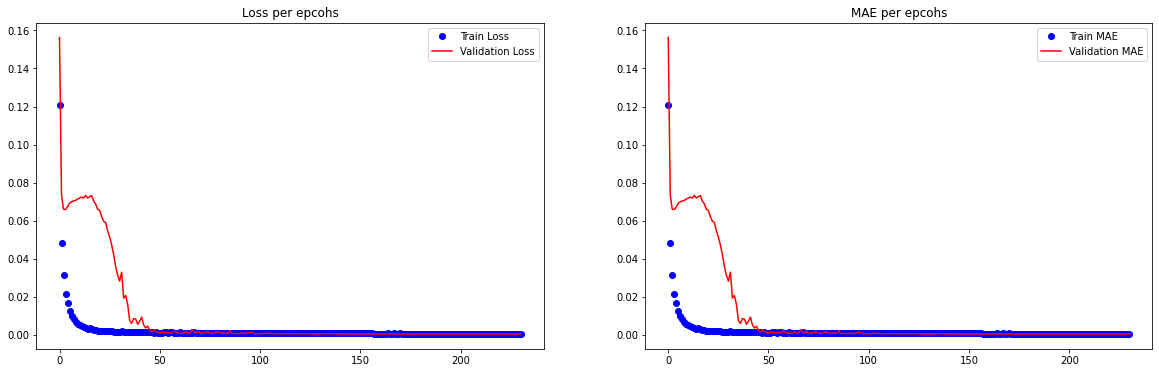

In [25]:
val_loss = history.history['val_loss']
loss = history.history['loss']
val_mae = history.history['val_mae']
mae = history.history['mae']

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(range(len(loss)), loss, 'bo', label = 'Train Loss')
plt.plot(range(len(val_loss)), val_loss, 'r-', label = 'Validation Loss')
plt.legend()
plt.title('Loss per epcohs')

plt.subplot(1,2,2)
plt.plot(range(len(mae)), loss, 'bo', label = 'Train MAE')
plt.plot(range(len(val_mae)), val_loss, 'r-', label = 'Validation MAE')
plt.legend()
plt.title('MAE per epcohs')

plt.show()

# 예측 및 평가

In [27]:
y_pred = model.predict(x_test, batch_size = batch_size)

9/9 [==============================] - 3s 417ms/step


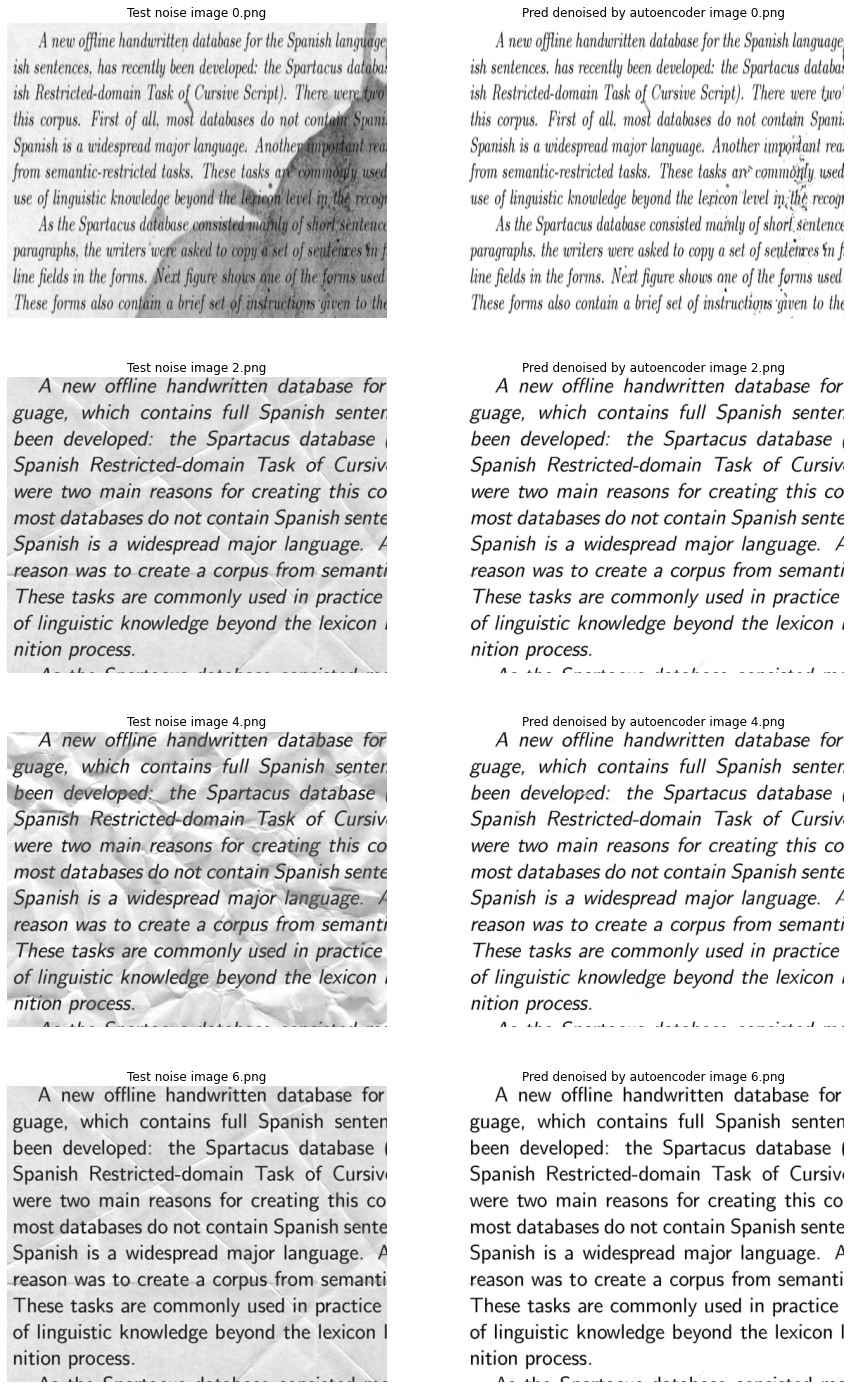

In [28]:
plt.figure(figsize = (15, 25))

for i in range(0, 8, 2):
  plt.subplot(4, 2, i + 1)
  plt.axis('off')
  plt.imshow(x_test[i][:,:,0], cmap = 'gray')
  plt.title(f'Test noise image {i}.png')

  plt.subplot(4, 2, i + 2)
  plt.axis('off')
  plt.imshow(y_pred[i][:,:,0], cmap = 'gray')
  plt.title(f'Pred denoised by autoencoder image {i}.png')

plt.show()